# Return times with rare event algorithms

This tutorial demonstrates some of the features of the `stochrare` package for rare event simulation.

As an example, we show how to compute *return times* using the block maximum method (a standard method applicable to any time series) and using a particular rare event algorithm, the *Adaptive Multilevel Splitting* algorithm.

Let us first import the modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import stochrare as sr
np.random.seed(seed=100)

As an illustration, we shall work with a very simple stochastic process, the *Ornstein-Uhlenbeck* process in 1D:

In [2]:
oup = sr.dynamics.diffusion1d.OrnsteinUhlenbeck1D(0, 1, 0.5)

We simulate a realization $x(t)$ of this process with many samples:

In [3]:
%%time
reftraj = oup.trajectory(0., 0., T=10000)

CPU times: user 1.31 s, sys: 25 ms, total: 1.34 s
Wall time: 1.32 s


We are interested in rare events corresponding to extreme values of the process. For instance, we represent below occurrences when the signal reaches a certain threshold $a$.

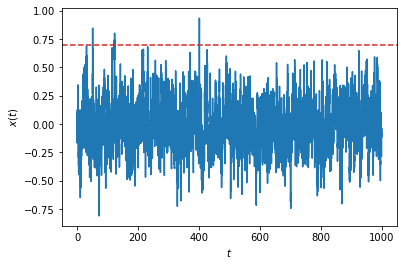

In [4]:
_, ax = sr.io.plot.trajectory_plot1d((reftraj[0][:10000], reftraj[1][:10000]));
ax.axhline(y=0.7, color='C3', ls='dashed');

Such events may be characterized by their probability of occurrence per unit time.
Conversely, one may consider the typical time associated with the event, for instance by looking at the average time between two successive independent events.
When the events are rare enough (i.e. the threshold $a$ is sufficiently large), the two quantities are inverse of each other. The event follow Poisson statistics, and the parameter of the Poisson distribution is the inverse of the average time between two successive independent events. This time is called the *return time* of the event. It is a very useful metric to quantify rare events.
In this notebook, we show how to compute the return time $r(a)$ as a function of the amplitude $a$ of the event using different methods.

This tutorial is inspired from the paper:

*Computing return times or return periods with rare event algorithms*, T. Lestang, F. Ragone, C.-E. Bréhier, C. Herbert and F. Bouchet, J. Stat. Mech. (2018).

## Return times with the block maximum method

The idea of the block maximum method is to divide the trajectory into $M$ blocks of duration $\Delta T$ (so that the total length of the trajectory is $T_d=M\Delta T$) much larger than the correlation time of the timeseries $\tau_c$ (to make sure that the events are independent). On each block, the maximum value is computed:

$$a_m = \max\{ x(t) \| (m-1)\Delta T \leq t \leq m\Delta T\}.$$

To the largest of these values, we associate a return time $T_d$, to the second largest value we associate a return time $T_d/2$, and so on.

This procedure is implemented in the `stochrare.timeseries.blockmaximum` routine. In addition to the time series itself, the block size $\Delta T$ should be given to the routine. It should be chosen such that $\tau_c \ll \Delta T \ll r(a)$.

In [5]:
%%time
aref, rref = zip(*sr.timeseries.blockmaximum(reftraj[1], 1000, mode='returntime', time=reftraj[0], modified=True))

CPU times: user 12 ms, sys: 5.31 ms, total: 17.3 ms
Wall time: 13.4 ms


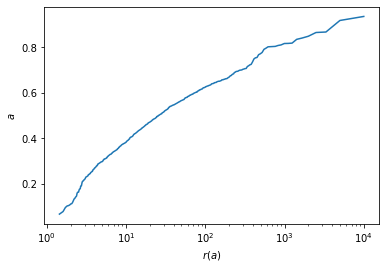

In [6]:
ax = plt.axes(xlabel=r'$r(a)$', ylabel=r'$a$', xscale='log')
ax.plot(rref, aref);

## Return times with the *Adaptive Multilevel Splitting* algorithm

As explained in Lestang et al. (2019), the method can be extended to non-equiprobable blocks like trajectories simulated by rare event algorithms.

As an example, we use the *Trajectory Adaptive Multilevel Splitting algorithm*, which is defined by a score function (below it is just the identity) and a fixed length for trajectories (equal to 5 below).
The idea of the algorithm is to evolve an ensemble of trajectories through selection-mutation steps.
At each iteration, the poorest performers of the ensemble (measured by the score function) are *killed* and replaced by a copy of a *surviving* trajectory resampled from the point where it reached the maximum score function level obtained by the killed trajectory.

We first define the `TAMS` object, which requires a dynamics, a score function and the duration for trajectories:

In [7]:
tams = sr.rare.ams.TAMS(oup, (lambda t, x: x), 5.)

Then, we run the algorithm. Here we use directly the `returntimes` method, which samples trajectories by running the algorithm and then computes the corresponding return times.
The method takes as arguments the number of member of the initial ensemble (here 100), and the number of iterations for the algorithm (here 600).

In [8]:
%%time
aams, rams = tams.returntimes(100, 600)

CPU times: user 726 ms, sys: 6.14 ms, total: 732 ms
Wall time: 732 ms


Let us compare the solution to the one obtained with the Block Maximum method:

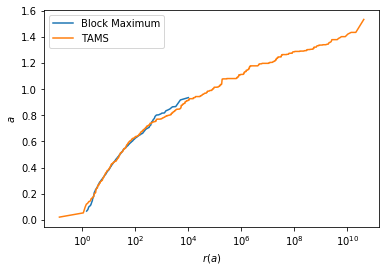

In [9]:
ax = plt.axes(xlabel=r'$r(a)$', ylabel=r'$a$', xscale='log')
ax.plot(rref, aref, label='Block Maximum');
ax.plot(rams, aams, label='TAMS');
ax.legend();

In this simple example, for a similar computational cost, the AMS algorithm allows to estimate return times 7 orders of magnitude larger than the Block Maximum method. This depends on the realization, and to properly characterize the performance of the AMS algorithm one would need to study the statistics over an ensemble of realizations.

## Applications of the rare event algorithms

For more information about application of the algorithm shown here to sample efficiently rare events, we refer the reader to the following articles:

- F. Cérou, A. Guyader, T. Lelièvre and D. Pommier, *J. Chem. Phys.* 134, 054108 (2011).
- J. Rolland, F. Bouchet and E. Simonnet, *J. Stat. Phys.* 162, 277–311 (2015).
- F. Ragone, J. Wouters and F. Bouchet, *Proc. Nat. Acad. Sci.* 115, 24-29 (2018).
- T. Lestang, F. Ragone, C.-E. Bréhier, C. Herbert and F. Bouchet, *J. Stat. Mech.* (2018).
- J. Rolland, *Phys. Rev. E* 97, 023109 (2018).
- F. Bouchet, J. Rolland and E. Simonnet, *Phys. Rev. Lett.* 122, 074502 (2019).

In addition, a recent review of the AMS algorithm can be found here:

- F. Cérou, A. Guyader, and M. Rousset, *Chaos* 29, 043108 (2019).